Environment Setup

Use magnitudes and phases resulting from DFT as input.
Input size now x2.
phase needs to be unwrapped
try conv layer hybrid

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
import models
import utils
import scipy.signal
import importlib
importlib.reload(models)
importlib.reload(utils)
from models import *
from utils import *
from torch.utils.tensorboard import SummaryWriter


# hyperparameters
samplerate = 44100
num_epochs = 100
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
# the f0 range is from 50 to 500 Hz, it should cover the longest f0 in the dataset, so 50Hz=0.02s
segment_length_in_seconds = 0.02
# noise level
segment_length_in_samples = int(segment_length_in_seconds * samplerate)
batch_size = 16
representation_type = 'Mel'

# STFT parameters
n_fft = 512
hop_length = 256
window = 'hann'
num_frames = 512
n_harmonics = 40


Data set building

In [13]:
# load all wav files in audio
audio = []
for root, dirs, files in os.walk('audio'):
    for file in files:
        if file.endswith('.wav'):
            audio.append(os.path.join(root, file))
raw_wav = []

# the audio is 2 channel audio, concatenate them along the time axis
for i in range(len(audio)):
    wav, _ = librosa.load(audio[i], sr=samplerate, mono=False)
    raw_wav = np.concatenate((raw_wav, wav), axis=-1) if i != 0 else wav

audio_wav = raw_wav[0]
egg_wav = raw_wav[1]

# preprocess the audio_wav and egg_wav
input_complex, target_complex, mag_min, mag_max = preprocess_data(audio_wav, egg_wav, n_fft, hop_length, n_harmonics, window)

# reshape the input_complex and target_complex
input_complex = reshape_to_fit_LSTM(input_complex, num_frames)
target_complex = reshape_to_fit_LSTM(target_complex, num_frames)

# split the data into train, validation and test set
(audio_train, egg_train), (audio_val, egg_val), (audio_test, egg_test) = split_data(input_complex, target_complex, 0.8, 0.1)

# Create PyTorch datasets
train_dataset = LSTM_VoiceDataset(audio_train, egg_train)
val_dataset = LSTM_VoiceDataset(audio_val, egg_val)
test_dataset = LSTM_VoiceDataset(audio_test, egg_test)

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(576, 512, 120)
(576, 512, 120)
-1.0 1.0
-1.0 1.0


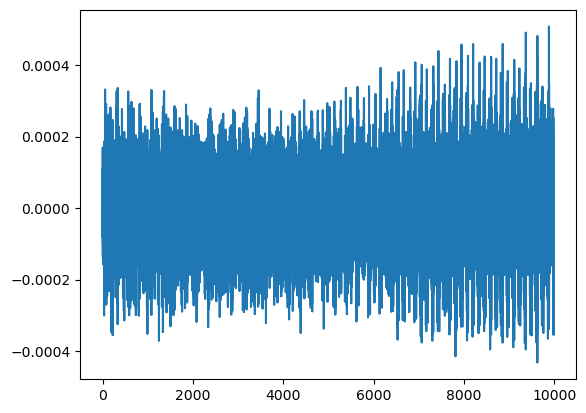

In [25]:
# check shape of the data
print(audio_train.shape)
print(egg_train.shape)

# check ranges of the data
print(np.min(audio_train), np.max(audio_train))
print(np.min(egg_train), np.max(egg_train))

# # plot the first frame of the input and target
# plt.figure()
# plt.subplot(2, 1, 1)
# plt.imshow(np.log1p(np.abs(audio_train[1, :, :40].T)), aspect='auto', origin='lower')
# plt.title('Input')
# plt.subplot(2, 1, 2)
# plt.imshow(np.log1p(np.abs(egg_train[1, :, :40].T)), aspect='auto', origin='lower')
# plt.title('Target')
# plt.show()

test_audio = target_complex[60, :, :]

def inverse_preprocess_data(complex_spectrogram, n_fft, hop_length, window, n_harmonics, mag_min=None, mag_max=None):
    # Assuming complex_spectrogram is the concatenated vector of magnitude, phase_sin, and phase_cos
    # Split the complex_spectrogram back into its components
    magnitude = complex_spectrogram[:, :n_harmonics]
    phase_sin = complex_spectrogram[:, n_harmonics:2*n_harmonics]
    phase_cos = complex_spectrogram[:, 2*n_harmonics:]
    
    # Reconstruct phase from sin and cos
    phase = np.arctan2(phase_sin, phase_cos)
    
    # Reverse normalization (if you applied it during preprocessing)
    # This step depends on how you've normalized your magnitude.
    # If you normalized it to a range of [-1, 1], reverse that process here.
    # Placeholder for magnitude normalization reversal
    
    # Reconstruct the complex stft results
    stft_reconstructed = magnitude * np.exp(1j * phase)
    
    # ISTFT to convert back to time domain
    y_inv = librosa.istft(stft_reconstructed, hop_length=hop_length, win_length=n_fft, window=window)
    
    return y_inv

y_inv = inverse_preprocess_data(test_audio, n_fft, hop_length, window, n_harmonics, mag_min, mag_max)
plt.plot(y_inv)
plt.show()



Epoch: 1/100, Training Loss: 0.2908, Validation Loss: 0.4971, LR: 0.001
Epoch: 2/100, Training Loss: 0.2893, Validation Loss: 0.4967, LR: 0.001
Epoch: 3/100, Training Loss: 0.2877, Validation Loss: 0.4981, LR: 0.001
Epoch: 4/100, Training Loss: 0.2849, Validation Loss: 0.5000, LR: 0.001
Epoch: 5/100, Training Loss: 0.2805, Validation Loss: 0.5047, LR: 0.001
Epoch: 6/100, Training Loss: 0.2766, Validation Loss: 0.5045, LR: 0.001
Epoch: 7/100, Training Loss: 0.2740, Validation Loss: 0.5069, LR: 0.001
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 8/100, Training Loss: 0.2721, Validation Loss: 0.5081, LR: 0.0001
Epoch: 9/100, Training Loss: 0.2681, Validation Loss: 0.5084, LR: 0.0001
Epoch: 10/100, Training Loss: 0.2667, Validation Loss: 0.5091, LR: 0.0001
Epoch: 11/100, Training Loss: 0.2658, Validation Loss: 0.5094, LR: 0.0001
Epoch: 12/100, Training Loss: 0.2651, Validation Loss: 0.5098, LR: 0.0001
Early stopping triggered


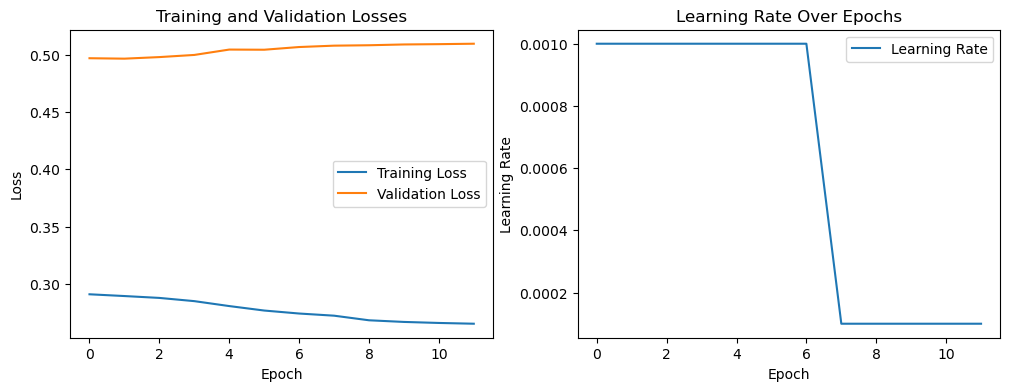

In [50]:
n_mels = n_harmonics * 3
model = LSTMmodel(n_mels=n_mels, hidden_size=hidden_size, num_layers=2)

log_name = f'{type(model).__name__}_{representation_type}_bs{batch_size}'
writer = SummaryWriter('runs/experiment_name')

sample_input = torch.randn(batch_size, segment_length_in_samples)
# writer.add_graph(model, sample_input)

tensorboard_log_config(writer, model, representation_type, samplerate, segment_length_in_seconds, batch_size)
trained_model = train_model(writer, model, train_loader, val_loader, num_epochs, learning_rate)
writer.close()


In [ ]:
model.eval()  # Ensure the model is in evaluation mode

predictions = []  # To store model predictions
actuals = []  # To store actual target values for comparison
audios = []  # To store audio samples

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:
        # Move data to the appropriate device (e.g., GPU if available)
        inputs = inputs.to(next(model.parameters()).device)
        
        # Compute model output
        output = model(inputs)
        
        predictions.append(output.cpu().numpy())  # Move prediction back to CPU and convert to numpy
        actuals.append(targets.cpu().numpy())  # Same for actual targets

for prediction in predictions:
    # Split the predictions into magnitude and sin and cos of phase
    pred_mag = prediction[:, :, :n_mels]
    pred_phase_sin = prediction[:, :, n_mels:2*n_mels]
    pred_phase_cos = prediction[:, :, 2*n_mels:]
        
    # Denormalize magnitude and phase
    pred_mag_denorm = denormalize(pred_mag, mag_min, mag_max)
    
    # reconstruct audio from magnitude and sin and cos of phase
    for mag, phase in zip(pred_mag_denorm, zip(pred_phase_sin, pred_phase_cos)):
        audio = reconstruct_audio(mag, phase, n_fft, hop_length, window)
        audios.append(audio)



In [ ]:
# Plot the input waveform, actual EGG spectrogram, and predicted EGG spectrogram for a random sample
idx = random.randint(0, len(predictions) - 1)
input_mel = reshaped_mel_input_test[idx, :, :]
target_mel = reshaped_mel_target_test[idx, :, :]
prediction_mel = predictions[idx]

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(np.abs(input_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Input Mel spectrogram')

plt.subplot(3, 1, 2)
plt.imshow(np.abs(target_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Target Mel spectrogram')

plt.subplot(3, 1, 3)
plt.imshow(np.abs(prediction_mel.T), aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.title('Predicted Mel spectrogram')

plt.tight_layout()
plt.show()

# Plot the input waveform, actual EGG waveform, and predicted EGG waveform for a random sample
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(audio_wav_test[idx])
plt.title('Input waveform')

plt.subplot(3, 1, 2)
plt.plot(egg_wav_test[idx])
plt.title('Target waveform')

plt.subplot(3, 1, 3)
plt.plot(audios[idx])
plt.title('Predicted waveform')

plt.tight_layout()
plt.show()